<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/1-computer-vision-lab/2-visualizing-filters-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing filters ##

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Change directories to point to your data!
data_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml'
specfic_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/MNIST.zip'
#!ls "$root_dir"
root_dir = "/content/data"

!unzip '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/MNIST.zip' -d "$root_dir"


Archive:  /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/MNIST.zip
   creating: /content/data/MNIST/
  inflating: /content/data/MNIST/.DS_Store  
  inflating: /content/data/__MACOSX/MNIST/._.DS_Store  
   creating: /content/data/MNIST/processed/
   creating: /content/data/MNIST/raw/
  inflating: /content/data/MNIST/processed/training.pt  
  inflating: /content/data/MNIST/processed/test.pt  
  inflating: /content/data/MNIST/raw/t10k-images-idx3-ubyte  
  inflating: /content/data/MNIST/raw/t10k-labels-idx1-ubyte  
  inflating: /content/data/MNIST/raw/train-images-idx3-ubyte  
  inflating: /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-images-idx3-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-labels-idx1-ubyte  
  inflating: /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz  


# Load the Dataset (MNIST)

In [8]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

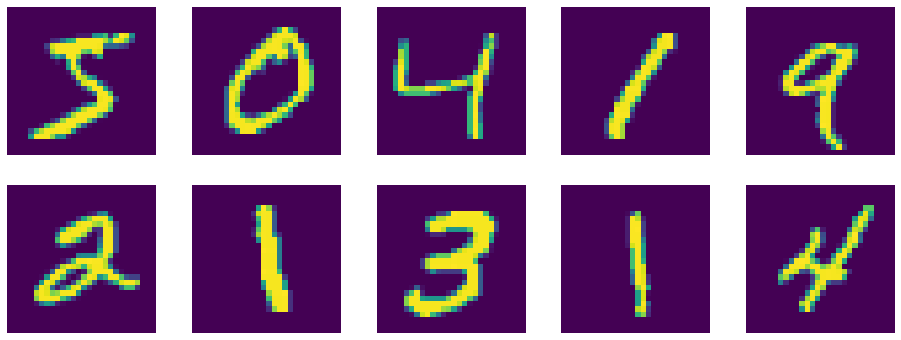

In [9]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset[i]
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [10]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [11]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.savefig('plotting_single_channel_filters', dpi=100)    
    plt.tight_layout()
    plt.show()

In [12]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('plotting_filters', dpi=100)    
    plt.tight_layout()
    plt.show()

In [13]:
def plot_weights(model, layer_num, single_channel = True):
  
    #extracting the model features at the particular layer number
    # in our case, we know it is layer 0 or 1 -- this needs to change if you want to visualize other models (adjust to your case)
    if layer_num == 0:
        layer = model.conv1
    else :
        layer = model.conv2

    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = layer.weight.data

        if single_channel:
            plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")

## Create the model ##

In [14]:
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
print(model_cnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [15]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train the Convnet ##

In [16]:
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.320925
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.841060
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.354644
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.384646
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.284483
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.230110
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.308999
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.126495
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.251323
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.117545

Test set: Average loss: 0.1767, Accuracy: 9465/10000 (95%)



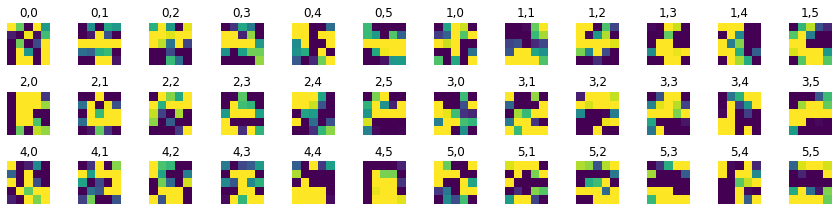

In [17]:
model_cnn.to('cpu')
plot_weights(model_cnn, 1, single_channel = True)

## When using another some pre-trained model ##

In [18]:
#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [19]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [20]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
def plot_weights(model, layer_num, single_channel = True):
  
    #extracting the model features at the particular layer number
    layer = model.features[layer_num] # Adjusted for Alexnet

    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = layer.weight.data
        print(weight_tensor.shape)

        if single_channel:
            plot_filters_single_channel(weight_tensor)

        else:
            if weight_tensor.shape[1] == 3: ## Multi channel is RGB more than that is better to print on its own
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")

torch.Size([64, 3, 11, 11])


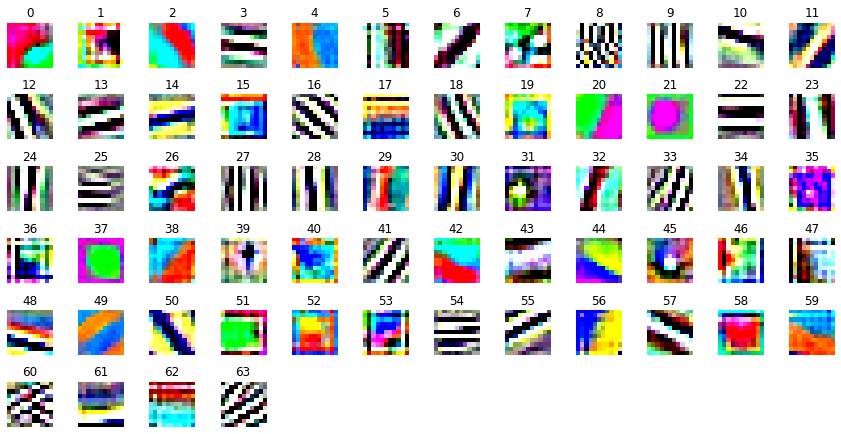

In [22]:
plot_weights(alexnet, 0, single_channel = False)
# plot_weights(alexnet, 0, single_channel = True)